## Exploratory Data Analysis (EDA)

##### Setup & Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
# Load helper functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_loader import load_data
from src.eda import plot_distribution, plot_box


##### Load Cleaned Data

In [ ]:
fraud_df = load_data("../data/fraud_cleaned.csv")
credit_df = load_data("../data/credit_cleaned.csv")
ip_df= load_data("../data/ip_cleaned.csv")

##### Univariate Analysis (E-commerce: fraud_df)

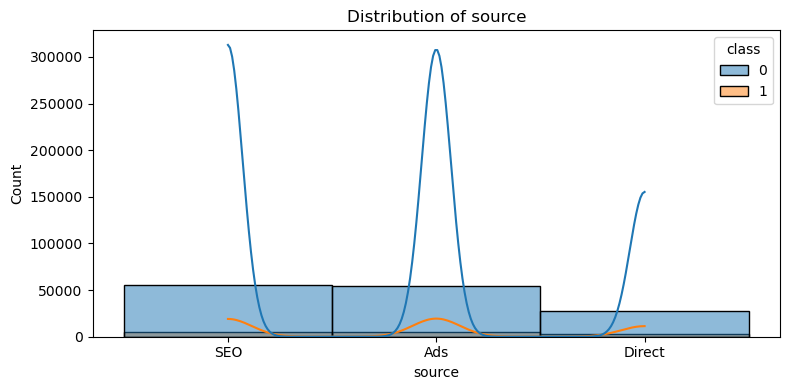

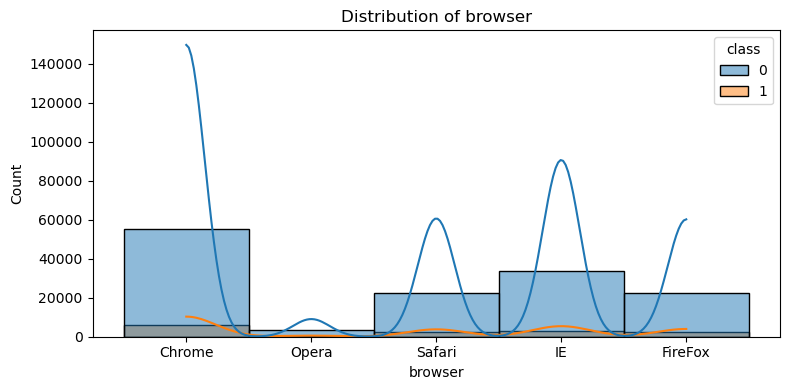

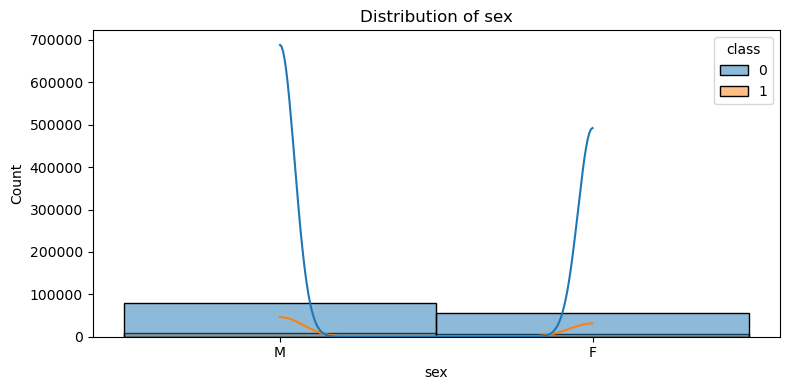

In [3]:
categorical = ['source', 'browser', 'sex']

for col in categorical:
    plot_distribution(fraud_df, col, hue='class')

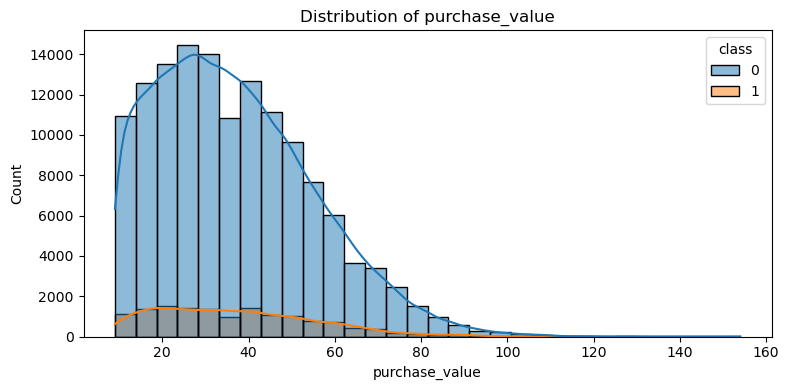

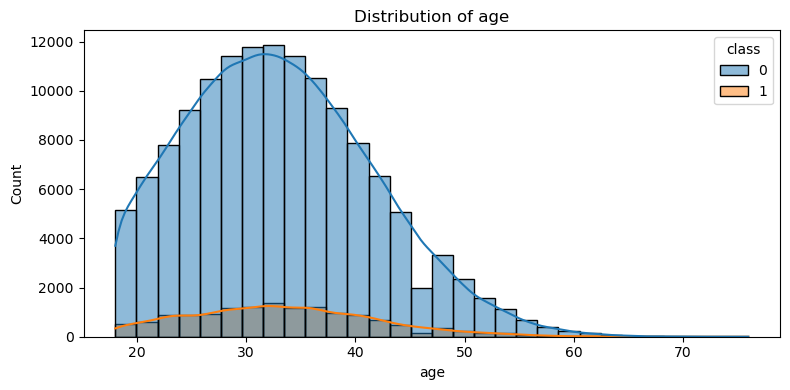

In [4]:
numerical = ['purchase_value', 'age',]
for col in numerical:
    plot_distribution(fraud_df, col, hue='class')

##### Bivariate Analysis (E-commerce)

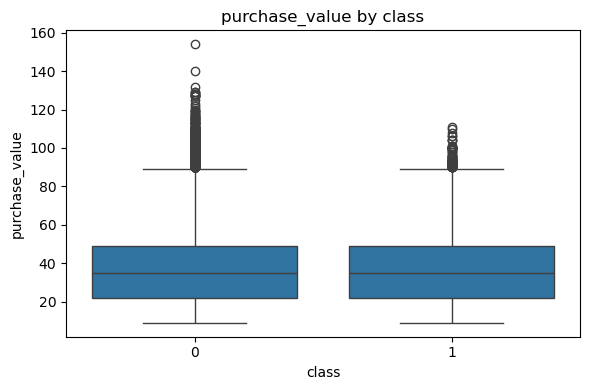

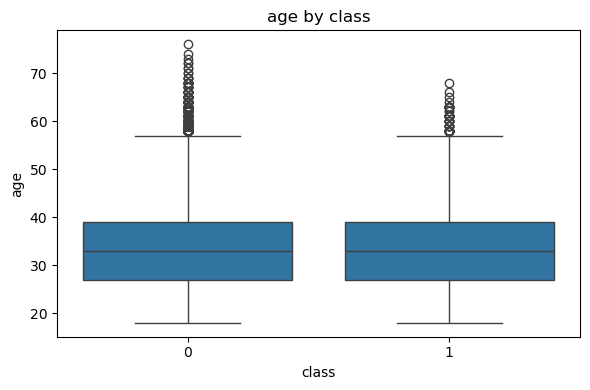

In [5]:
for col in numerical:
    plot_box(fraud_df, x='class', y=col)

##### Univariate Analysis (Bank: credit_df)

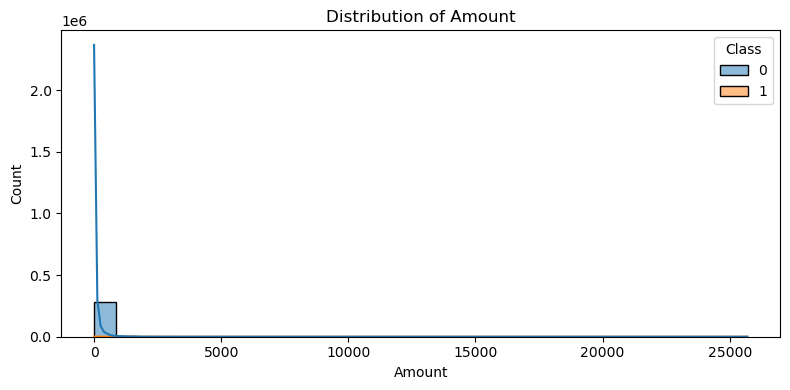

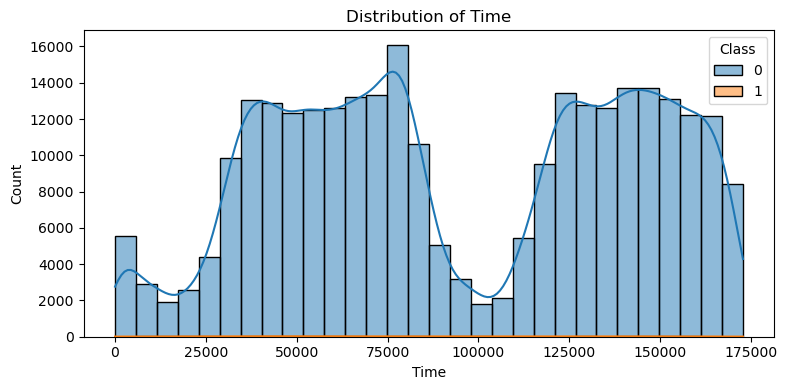

In [6]:
plot_distribution(credit_df, 'Amount', hue='Class')
plot_distribution(credit_df, 'Time', hue='Class')

##### Correlation Matrix (Bank)

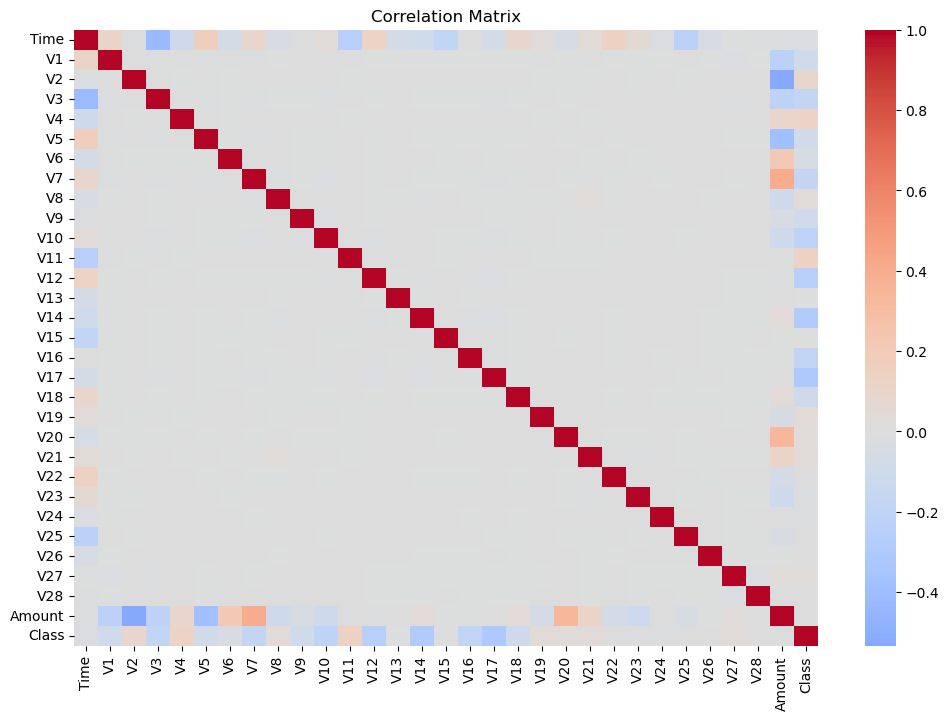

In [7]:
corr = credit_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


##### Fraud Rate Summary

In [8]:
print("Fraud Rate in E-commerce:", fraud_df['class'].mean())
print("Fraud Rate in Bank:", credit_df['Class'].mean())

Fraud Rate in E-commerce: 0.09364577267192546
Fraud Rate in Bank: 0.001667101358352777


### Merge Datasets for Geolocation Analysis

In [ ]:
# Convert IPs are integers
fraud_df['ip_address_int'] = fraud_df['ip_address'].astype(float).astype(int)
ip_df['lower_bound_ip_int'] = ip_df['lower_bound_ip_address'].astype(float).astype(int)
ip_df['upper_bound_ip_int'] = ip_df['upper_bound_ip_address'].astype(float).astype(int)

# Define function to map IP to country
def find_country(ip_int, ip_df):
    match = ip_df[
        (ip_df['lower_bound_ip_int'] <= ip_int) &
        (ip_df['upper_bound_ip_int'] >= ip_int)
    ]
    return match['country'].values[0] if not match.empty else 'Unknown'

# Apply it to the fraud dataframe
fraud_df['country'] = fraud_df['ip_address_int'].apply(lambda ip: find_country(ip, ip_df))


##### Save the merged dataset (fraud + geolocation)

In [10]:
fraud_df.to_csv("../data/merged_fraud_geo.csv", index=False)

##### Top Countries by Fraud

In [11]:
fraud_by_country = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)
print(fraud_by_country.head(10))

country
Virgin Islands (U.S.)    1.000000
Turkmenistan             1.000000
Luxembourg               0.555556
Sri Lanka                0.520000
Kuwait                   0.280702
New Zealand              0.254902
Uzbekistan               0.250000
Saudi Arabia             0.238095
Ireland                  0.220930
Hong Kong                0.199203
Name: class, dtype: float64


#  Fraud Detection EDA Summary

##  Overview

- **E-commerce fraud rate**: ~9.36%  
- **Bank fraud rate**: ~0.17%

> Fraud is significantly more common in the e-commerce dataset, which suggests it is more vulnerable to fraud attacks compared to the bank data.

---

##  Numerical Features

### 1. `purchase_value`
- **Mean (Fraud vs. Non-Fraud)**: ~37 (no significant difference)  
**Insight**: Not a useful predictor of fraud — purchase amounts are similar across both classes.

### 2. `age`
- **Mean Age**: ~33 in both classes  
**Insight**: No meaningful difference — not a predictive feature.

### 3. `hour_of_day`
- **Peak Activity**: Around 12 PM for both fraud and non-fraud  
**Insight**: Minimal variation across classes; not significant.

### 4. `day_of_week`
- **Slight Peak**: Fraud peaks mid-week (Wednesdays/Thursdays)  
**Insight**: Only marginal difference.

### 5. `time_since_signup` (in hours)
- **Fraud Mean**: ~1330 hrs  
- **Non-Fraud Mean**: ~2161 hrs  
- **Correlation with Fraud**: -0.26  
**Insight**: Most important feature – fraud happens sooner after signup. Strong negative correlation with fraud.

---

##  Categorical Features

###  `source`

| Source | Fraud Rate |
|--------|------------|
| Ads    | 9.2%       |
| SEO    | 8.9%       |
| Direct | 10.5%      |

**Insight**: Users coming via "Direct" traffic show a higher fraud rate — may indicate bots or manual attacks.

###  `browser`

| Browser | Fraud Rate |
|---------|------------|
| Chrome  | 9.88%      |
| FireFox | 9.52%      |
| IE      | 8.67%      |
| Safari  | 9.02%      |
| Opera   | 8.92%      |

**Insight**: Very similar fraud rates across browsers. No strong indicator.

###  `sex`

| Sex | Fraud Rate |
|-----|------------|
| F   | 9.1%       |
| M   | 9.5%       |

**Insight**: Males show slightly higher fraud rates, but difference is minimal.

---

##  Correlation with Fraud

| Feature            | Correlation |
|--------------------|-------------|
| time_since_signup  | **-0.26**   |
| day_of_week        | 0.019       |
| age                | 0.007       |
| hour_of_day        | 0.002       |
| purchase_value     | 0.001       |

> Only `time_since_signup` shows meaningful correlation. Other features have negligible correlation with fraud.

---

##  Key Takeaways

- `time_since_signup` is the most predictive feature of fraud.
- `source = Direct` is slightly riskier than Ads/SEO.
- Most other features (`age`, `purchase_value`, `browser`, etc.) offer limited discriminatory power.
- Correlation analysis confirms most features are weak predictors individually.

---

##  Top Countries by Fraud Rate

| Country               | Fraud Rate |
|-----------------------|------------|
| Virgin Islands (U.S.) | 1.000000   |
| Turkmenistan          | 1.000000   |
| Luxembourg            | 0.555556   |
| Sri Lanka             | 0.520000   |
| Kuwait                | 0.280702   |
| New Zealand           | 0.254902   |
| Uzbekistan            | 0.250000   |
| Saudi Arabia          | 0.238095   |
| Ireland               | 0.220930   |
| Hong Kong             | 0.199203   |

---
